Epoch 1/15
2565/2573 [============================>.] - ETA: 0s - loss: 1.2259 - accuracy: 0.5119
Epoch 1: saving model to mixedModel.h5
2573/2573 [==============================] - 19s 7ms/step - loss: 1.2244 - accuracy: 0.5126 - val_loss: 1.2435 - val_accuracy: 0.4829
Epoch 2/15
  31/2573 [..............................] - ETA: 13s - loss: 1.2308 - accuracy: 0.5161

/home/tom/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2573/2573 [==============================] - ETA: 0s - loss: 1.1461 - accuracy: 0.5325
Epoch 2: saving model to mixedModel.h5
2573/2573 [==============================] - 12s 5ms/step - loss: 1.1461 - accuracy: 0.5325 - val_loss: 1.1815 - val_accuracy: 0.5217
Epoch 3/15
2562/2573 [============================>.] - ETA: 0s - loss: 1.1176 - accuracy: 0.5410
Epoch 3: saving model to mixedModel.h5
2573/2573 [==============================] - 12s 5ms/step - loss: 1.1192 - accuracy: 0.5410 - val_loss: 1.1308 - val_accuracy: 0.5357
Epoch 4/15
2572/2573 [============================>.] - ETA: 0s - loss: 1.1067 - accuracy: 0.5463
Epoch 4: saving model to mixedModel.h5
2573/2573 [==============================] - 12s 5ms/step - loss: 1.1067 - accuracy: 0.5464 - val_loss: 1.1597 - val_accuracy: 0.5280
Epoch 5/15
2573/2573 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.5585
Epoch 5: saving model to mixedModel.h5
2573/2573 [==============================] - 14s 6ms/step - l

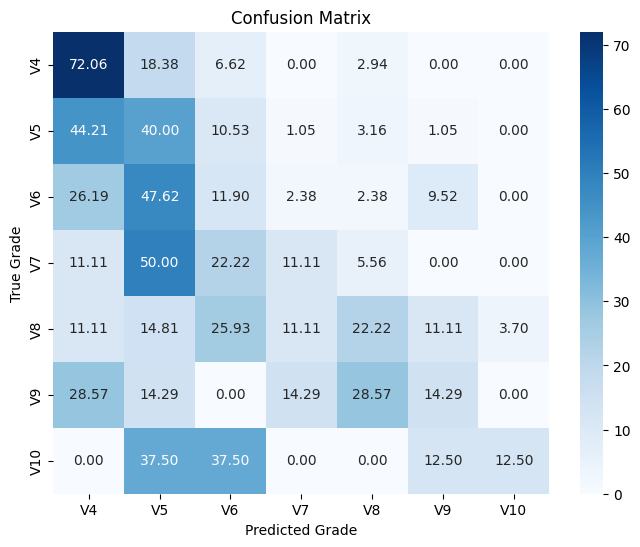

In [44]:
import numpy as np
import ast
import re
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold


def extract_repeats(text):
    ''' Extracts number of repeates '''
    numeric_value = re.search(r'\d+', text)
    if numeric_value:
        return int(numeric_value.group())
    else:
        return None

def remLowRepeats(df):
    ''' Removes climbs with less than 20 repeats ''' 
    # Apply the function to the 'RepeatText' column
    df['RepeatText'] = df['RepeatText'].apply(extract_repeats)
    return df[df['RepeatText']>=20]

def preprocess(df):
    # Define global test set (Unseen data) to unsure no leakage 
    global testSet
    # 2017 set
    #df = pd.read_csv('trainingFinal.csv')
    # 2016 set
    #df = pd.read_csv('testSetFinal.csv')
    df = remLowRepeats(df)
    
    hold_types = ["Small Crimp", "Medium Crimp", "Large Crimp", "Pocket", "Small Pocket", "Jug", "Small Pinch", "Medium Pinch", "Large Pinch", "Slopy Pinch", "Sloper"]
    
    # Process input data for each problem in the DataFrame
    encoded_inputs = []
    grades = []
    
    for input_data, grade in zip(df['Input'], pd.to_numeric(df['V_Grade'], errors='coerce')):
        try:
            input_data_list = ast.literal_eval(input_data)
            encoded_seq = []
            
            for seq in input_data_list:
                current_hold1, current_hold2, target_hold, distance = seq
                encoded_hold = [0] * (len(hold_types) + 1)  # +1 for the distance
                
                if current_hold1 in hold_types:
                    encoded_hold[hold_types.index(current_hold1)] = 1
                if current_hold2 in hold_types:
                    encoded_hold[hold_types.index(current_hold2)] = 1
                if target_hold in hold_types:
                    encoded_hold[hold_types.index(target_hold)] = 1
                
                # Append the distance as the last element of the encoded sequence
                encoded_hold[-1] = distance
                
                encoded_seq.append(encoded_hold)
    
            if not np.isnan(grade) and 4 <= int(grade) <= 10:  # Only append if grade is not NaN and only take V4-V10
                encoded_inputs.append(encoded_seq)
                grade = int(grade)
                grades.append(grade)
            
        except:
            continue
    # Convert grades to a numpy array
    grades = np.array(grades)
    # Pad sequences with masking to a length of 12
    max_seq_length = 12
    padded_inputs = pad_sequences(encoded_inputs, padding='post', dtype='float32', maxlen=max_seq_length)

    return padded_inputs, grades


def train():
    #padded_inputs, grades = preprocess(pd.read_csv('testSetFinal.csv'))
    padded_inputs, grades = preprocess(pd.read_csv('mixedTrain.csv'))
    # Convert grades to categorical labels
    num_classes = 7  # Number of grade categories (V4-V10)
    grades_categorical = np.zeros((grades.shape[0], num_classes))
    
    for i, grade in enumerate(grades):
        grade_category = int(grade) - 4  # Assuming your grades are 3, 4, 5, ...
        grades_categorical[i, grade_category] = 1
    
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        padded_inputs, grades_categorical, test_size=0.2, random_state=None
    )

    # Create an LSTM model
    model = Sequential()
    
    # Add masking layer
    model.add(Masking(mask_value=0.0, input_shape=(padded_inputs.shape[1], padded_inputs.shape[2])))
    
    # Generally less nodes works well for generalised problems
    model.add(LSTM(128, return_sequences=False))
    
    # Add Dense output layer with num_classes units and softmax activation
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model with categorical cross-entropy loss
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Create a ModelCheckpoint callback to save the model after the last epoch
    checkpoint_callback = ModelCheckpoint(
        'mixedModel.h5',       # Filepath to save the model
        save_best_only=False,   # Save the model after each epoch
        save_weights_only=False,  # Save the entire model (including architecture)
        save_freq='epoch',      # Save after each epoch
        verbose=1               # Print messages about saving
    )

    # Train the model with the checkpoint callback and validation data (to check for overfitting)
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=1, callbacks=[checkpoint_callback])

    return model

def evaluate(model, X_test, y_test):
    grade_labels = ["V4", "V5", "V6", "V7", "V8", "V9", "V10"]

    # Convert y_test to categorical labels
    num_classes = 7  # Number of grade categories (V4-V10)
    y_test_categorical = np.zeros((y_test.shape[0], num_classes))
    for i, grade in enumerate(y_test):
        grade_category = int(grade) - 4
        y_test_categorical[i, grade_category] = 1

    # Make predictions using the model
    y_pred = model.predict(X_test)
    # Convert predicted probabilities to class labels
    y_pred_class = np.argmax(y_pred, axis=1)

    # Convert y_test_categorical back to original grade labels
    y_test_original = np.argmax(y_test_categorical, axis=1)

    # Calculate custom accuracy within +/- 1 grade range
    correct_count = 0
    correct_count_within_one = 0  # Initialize a count for within +/- one grade
    for true_grade, pred_grade in zip(y_test_original, y_pred_class):
        if abs(true_grade - pred_grade) <= 1:
            correct_count_within_one += 1
        if true_grade == pred_grade:
            correct_count += 1
    custom_accuracy = correct_count / len(y_test_original)
    custom_accuracy_within_one = correct_count_within_one / len(y_test_original)

    # Evaluate the model on the test set
    test_loss = model.evaluate(X_test, y_test_categorical, verbose=0)

    # Create a confusion matrix
    confusion_mat = confusion_matrix(y_test_original, y_pred_class)

    return custom_accuracy, custom_accuracy_within_one, test_loss[0], confusion_mat


def main():
    # Test Set 
    padded_inputs, grades = preprocess(pd.read_csv('2017Test.csv'))
    padded_inputs = padded_inputs[:, :12, :]  # Set the size to 12 s.t. consistent with each dataset
    # Train model
    model = train()
    #evaluate(model, padded_inputs, grades)
    accuracy,plusminusone,_,confusion_mat = evaluate(model, padded_inputs, grades)
   
   # Print the metrics
    print(f"Custom Accuracy: {accuracy:.2%}")
    print(f"Custom Accuracy Within +/- 1 Grade Range: {plusminusone:.2%}")

    grade_labels = ["V4", "V5", "V6", "V7", "V8", "V9", "V10"]
    # Normalise the confusion matrix to percentages
    row_sums = confusion_mat.sum(axis=1, keepdims=True)
    confusion_mat_percent = (confusion_mat / row_sums) * 100

    # Visualise the confusion matrix using Seaborn's heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat_percent, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=grade_labels, yticklabels=grade_labels)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Grade")
    plt.ylabel("True Grade")
    plt.show()

main()